In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
#import graphviz
import itertools

%matplotlib inline
#import mglearn
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder
import sklearn.decomposition as decomposition
# models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(-0.5,1.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Load Data

In [4]:
master_train = pd.read_csv('datathon2020_train.csv')
master_test = pd.read_csv('datathon2020_test.csv')
sub_format = pd.read_csv('datathon2020_test_sample_submission.csv')

In [5]:
master_train.shape, master_test.shape, sub_format.shape

((500, 52), (2486, 52), (2486, 2))

In [6]:
# checking for NANs
print(pd.isnull(master_train).sum().sum())
print(pd.isnull(master_test).sum().sum()) 

6457
32071


In [7]:
# print(pd.isnull(master_train).sum())

## Drop NaN

In [8]:
cols_to_drop = ['F2', 'F3', 'F4', 'F8', 'F11, ''F25', 'F77', 'F79', 'F98', 'F99', 'F116', 'F121', 'F122', 'F123', 'F124', 'F125', 'F126', 'F127', 'F128', 'F129', 'F130', 'F131', 'F132', 'F133', 'F136', 'F139']
master_train.drop(cols_to_drop,axis=1, inplace=True)
master_test.drop(cols_to_drop,axis=1, inplace=True)

KeyError: "['F11, F25'] not found in axis"

In [9]:
master_train.shape, master_test.shape

((500, 52), (2486, 52))

In [12]:
master_train.dtypes

ID              int64
F8             object
F11            object
F39           float64
F52           float64
F53           float64
F54           float64
F55           float64
F69           float64
F72           float64
F73           float64
F74           float64
F75           float64
F76           float64
F78           float64
F81           float64
F82           float64
F83           float64
F84           float64
F85           float64
F86           float64
F92           float64
F93           float64
F94           float64
F95           float64
F109          float64
F110          float64
COVID_TCPM     object
dtype: object

In [11]:
na_percents_train = master_train.isna().sum() / len(master_train) * 100
na_percents_test = master_test.isna().sum() / len(master_test) * 100

In [12]:
drop_these_train = na_percents_train[na_percents_train > 50.0].index.tolist()
drop_these_test = na_percents_test[na_percents_test > 50.0].index.tolist()

In [13]:
master_train.drop(columns=drop_these_train, axis=1, inplace=True)
master_test.drop(columns=drop_these_test, axis=1, inplace=True)

In [14]:
# checking for NANs
# before 6457, 32071
print(pd.isnull(master_train).sum().sum())
print(pd.isnull(master_test).sum().sum())

387
2117


In [15]:
pd.isnull(master_test).sum()

ID              0
F8              3
F11             8
F39            91
F69           113
F76            15
F78            10
F82           967
F83           908
F109            1
F110            1
COVID_TCPM      0
dtype: int64

## _Marking imputed values_

In [16]:
transformer = FeatureUnion(
    transformer_list=[
        ('categorical_features', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('indicators', MissingIndicator())])
transformer = transformer.fit(master_train)
results = transformer.transform(master_train)
results.shape

(500, 18)

## _SimpleImputer Imputing Values Train_

In [17]:
most_frequent_imputer  = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
most_frequent_imputer = most_frequent_imputer.fit(master_train)
train_imputed_df = most_frequent_imputer.transform(master_train)
train_imputed_df = pd.DataFrame(train_imputed_df, columns=master_train.columns)

In [18]:
print(pd.isnull(train_imputed_df).sum().sum())

0


## _SimpleImputer Imputing Values Test_

In [19]:
most_frequent_imputer  = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
most_frequent_imputer = most_frequent_imputer.fit(master_test)
test_imputed_df = most_frequent_imputer.transform(master_test)
test_imputed_df = pd.DataFrame(test_imputed_df, columns=master_train.columns)

### Copy DataFrames

In [20]:
# copy 
df_train = train_imputed_df.copy()
df_test = test_imputed_df.copy()
df_train.shape
df_test.shape

(500, 12)

(2486, 12)

## _Label Encoding_

In [21]:
df_train['F8'] = df_train['F8'].astype('category')
df_train['F11'] = df_train['F11'].astype('category')
# df_train['F136'] = df_train['F136'].astype('category')

df_test['F8'] = df_test['F8'].astype('category')
df_test['F11'] = df_test['F11'].astype('category')
# df_test['F136'] = df_test['F136'].astype('category')

In [22]:
# F8, F11, F136
df_train['F8'] = df_train['F8'].cat.codes
df_train['F11'] = df_train['F11'].cat.codes
# df_train['F136'] = df_train['F136'].cat.codes


df_test['F8'] = df_test['F8'].cat.codes
df_test['F11'] = df_test['F11'].cat.codes
# df_test['F136'] = df_test['F136'].cat.codes

In [23]:
df_train.shape, df_test.shape

((500, 12), (2486, 12))

## Target Class Extract & Drop

In [24]:
df_train_trgt = df_train[['COVID_TCPM']]
df_train.drop(['COVID_TCPM'], axis=1, inplace=True)

In [25]:
df_test_trgt = df_test[['COVID_TCPM']]
df_test.drop(['COVID_TCPM'], axis=1, inplace=True)

## Special Encode of Target Class

In [26]:
# master_train['COVID_TCPM'] = master_train['COVID_TCPM'].apply((lambda x: 'low' if x == 0 else 'high'))
# df_train_trgt['COVID_TCPM'] = df_train_trgt['COVID_TCPM'].apply((lambda x: 0 if x == 'low' else 1))
# df_test_trgt['COVID_TCPM'] = df_test_trgt['COVID_TCPM'].apply((lambda x: 0 if x == 'low' else 1))

In [27]:
le = LabelEncoder()
le.fit(df_train_trgt.values.ravel())
le.classes_

LabelEncoder()

array(['high', 'low'], dtype=object)

## Normalize Data

In [28]:
pca_train = df_train.copy()
pca_test = df_test.copy()

In [29]:
scl_min_max = MinMaxScaler()
scl_min_max.fit(pca_train)
scl_min_max.fit(pca_test)

data_train_mm = scl_min_max.transform(pca_train)
data_test_mm = scl_min_max.transform(pca_test)

scl_norm = Normalizer()
scl_norm.fit(pca_train)
scl_norm.fit(pca_test)

data_train_sm = scl_norm.transform(pca_train)
data_test_sm = scl_norm.transform(pca_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

Normalizer(copy=True, norm='l2')

Normalizer(copy=True, norm='l2')

In [30]:
scaled_train = pd.DataFrame(data_train_mm, columns = pca_train.columns)
scaled_test = pd.DataFrame(data_test_mm, columns = pca_test.columns)

In [31]:
# df_train = scaled_train.copy()
# df_train = scaled_test.copy()

In [32]:
X_train = df_train.copy()
y_train = df_train_trgt.copy()

X_test = df_test.copy()
y_test = df_test_trgt.copy()

## PCA

In [33]:
pca = decomposition.PCA()

In [34]:
pca.fit(scaled_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [35]:
pca.explained_variance_

array([1.09613404e-01, 8.07987956e-02, 4.43427744e-02, 2.59168532e-02,
       7.60330470e-03, 2.22847551e-04, 7.50700416e-05, 3.45184123e-05,
       9.44426753e-06, 1.58534347e-06, 3.06991639e-07])

In [36]:
len(pca.explained_variance_)

11

In [37]:
xlabels = list(range(1, len(pca.explained_variance_)+1))
xlabels[0:5]

[1, 2, 3, 4, 5]

([<matplotlib.axis.XTick at 0x19e2e1be8c8>,
 <a list of 11 Text xticklabel objects>)

Text(0.5, 1.0, 'Screeplot of PC-explained Variances')

Text(0.5, 0, 'PC')

Text(0, 0.5, 'Variance')

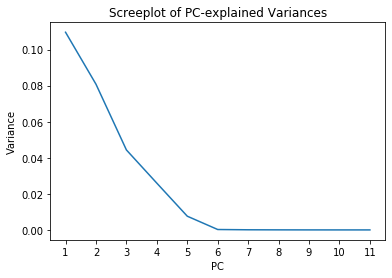

In [38]:
plt.plot(xlabels, pca.explained_variance_)
plt.xticks(xlabels)
plt.title("Screeplot of PC-explained Variances")
plt.xlabel("PC")
plt.ylabel("Variance")
plt.show()

In [39]:
data_rotated = pca.transform(scaled_train)

In [40]:
projected_data = data_rotated[:,0:8]
projected_data.shape

(500, 8)

In [41]:
# y_train['COVID_TCPM'] = y_train['COVID_TCPM'].apply((lambda x: 0 if x == 'low' else 1))

# response = y_train.values
# response

## Decision Tree Classifier

### DT with pipeline

In [42]:
# clf = make_pipeline(transformer, dt())
# clf = clf.fit(X_train, y_train)
# results = clf.predict(X_test)
# results.shape

In [43]:
# print(f'The training score for Decision Tree is: {(clf.score(X_train, y_train)*100):.2f}%')

In [44]:
# print(f'The test score for Decision Tree is: {(clf.score(X_test,y_test)*100):.2f}%')

In [130]:
clf_dt = dt(criterion='entropy', splitter='best', max_depth=None, min_samples_split=10, min_samples_leaf=6, max_features='auto', ccp_alpha=0.1)
clf_dt = clf_dt.fit(X_train, y_train.values.ravel())
dt_pred = clf_dt.predict(X_test)

In [131]:
print(f'The training score for Decision Tree is: {(clf_dt.score(X_train, y_train)*100):.2f}%')

The training score for Decision Tree is: 77.80%


In [132]:
print(f'The test score for Decision Tree is: {(clf_dt.score(X_test,y_test)*100):.2f}%')

The test score for Decision Tree is: 33.47%


## Random Forest

In [48]:
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X_train, y_train.values.ravel())

<Figure size 432x288 with 0 Axes>

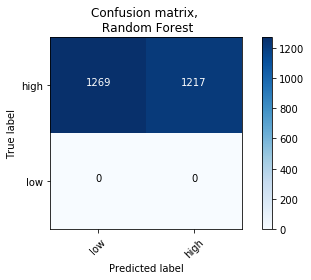

In [49]:
pred_rf = clf_rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, pred_rf)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['low', 'high'],
                      title='Confusion matrix, \n Random Forest')

In [50]:
print(classification_report(y_test, pred_rf, target_names=['low', 'high']))

              precision    recall  f1-score   support

         low       0.00      0.00      0.00         0
        high       1.00      0.49      0.66      2486

    accuracy                           0.49      2486
   macro avg       0.50      0.24      0.33      2486
weighted avg       1.00      0.49      0.66      2486



C:\Users\hamdanjuma\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# accuracy of model
accuracy_score(y_test, pred_rf)

0.4895414320193081

In [52]:
print(f'The training score for Random Forest is: {(clf_rf.score(X_train, y_train)*100):.2f}%')

The training score for Random Forest is: 100.00%


In [53]:
print(f'The test score for Random Forest is: {(clf_rf.score(X_test,y_test)*100):.2f}%')

The test score for Random Forest is: 48.95%


C:\Users\hamdanjuma\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature ranking:
1. feature 0 (0.280445)
2. feature 1 (0.119831)
3. feature 7 (0.116054)
4. feature 4 (0.093972)
5. feature 8 (0.081471)
6. feature 10 (0.063017)
7. feature 2 (0.055103)
8. feature 6 (0.053083)
9. feature 5 (0.049226)
10. feature 3 (0.045648)
11. feature 9 (0.042151)


<Figure size 720x864 with 0 Axes>

Text(0.5, 1.0, 'Feature importances')

<BarContainer object of 11 artists>

([<matplotlib.axis.XTick at 0x19e2e391748>,
 <a list of 11 Text xticklabel objects>)

(-1, 11)

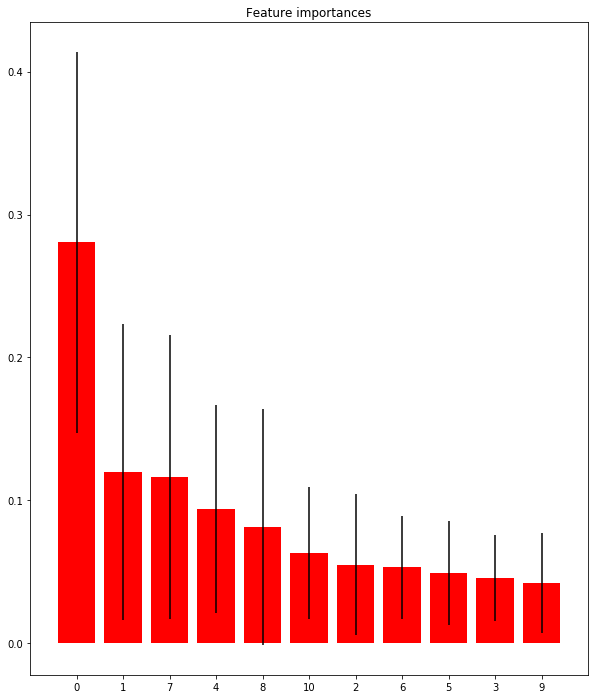

In [54]:
# forest.fit(X_train, y_train)
clf_rf = clf_rf.fit(X_train, y_train)
X = X_train
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,12))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [55]:
def plot_feature_importances (model, feature_names):
    n_features = model.n_features_
    plt.figure(figsize=(10,12))
    plt.barh(range(n_features),
             model.feature_importances_, 
             align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

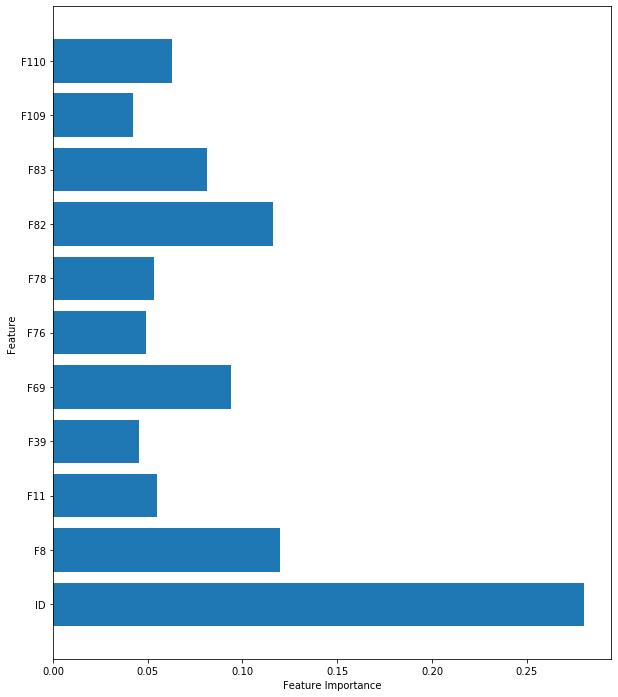

In [56]:
plot_feature_importances(clf_rf, df_train.columns)

In [57]:
# feature_imp = pd.DataFrame(np.transpose(clf_rf.feature_importances_))
# feature_imp = feature_imp.T
# mapper = {i:v for i, v in enumerate(X_train.columns)}
# feature_imp.rename(columns=mapper, inplace=True)
# feature_imp = feature_imp.T
# feature_imp[feature_imp < 0.02]

In [58]:
# features_to_drop = feature_imp[feature_imp < 0.02]
# features_to_drop.dropna(inplace=True)
# features_to_drop.shape # drop 19 features 

In [59]:
# features_to_drop = features_to_drop.reset_index()
# features_to_drop

In [60]:
# X_train.drop(features_to_drop['index'], axis=1, inplace=True)

In [61]:
# X_test.drop(features_to_drop['index'], axis=1, inplace=True)

In [62]:
# X_train.shape, X_test.shape

## Random Forest w/ GridSearchCV

In [63]:
params_rf = {"n_estimators":[100, 200, 300], "criterion":["gini","entropy"], "max_depth":[2,3,5,7]}
clf_gs_rf = GridSearchCV(clf_rf, params_rf, cv=5, return_train_score=True)
clf_gs_rf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [64]:
rf_params = clf_gs_rf.cv_results_['params'][clf_gs_rf.best_index_]
rf_params

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200}

In [65]:
clf_rf_opt = RandomForestClassifier(criterion=rf_params["criterion"], max_depth=rf_params["max_depth"], n_estimators=rf_params["n_estimators"])
clf_rf_opt = clf_rf_opt.fit(X_train, y_train.values.ravel())
pred_rf_opt = clf_rf_opt.predict(X_test)

In [66]:
print(f'The training score for Random Forest is: {(clf_rf_opt.score(X_train, y_train)*100):.2f}%')
print(f'The test score for Random Forest is: {(clf_rf_opt.score(X_test,y_test)*100):.2f}%')

The training score for Random Forest is: 99.60%
The test score for Random Forest is: 49.28%


In [67]:
# feature_imp_clf_rf_opt = pd.DataFrame(np.transpose(clf_rf_opt.feature_importances_))
# feature_imp_clf_rf_opt = feature_imp_clf_rf_opt.T
# mapper = {i:v for i, v in enumerate(df_train.columns)}
# feature_imp_clf_rf_opt.rename(columns=mapper, inplace=True)
# feature_imp_clf_rf_opt = feature_imp_clf_rf_opt.T
# feature_imp_clf_rf_opt[feature_imp_clf_rf_opt > 0.028571]

In [68]:
# feature_imp_clf_rf_opt.mean()

In [69]:
# list(features_to_drop_2['index'])


In [70]:
# features_to_drop_2 = feature_imp_clf_rf_opt[feature_imp_clf_rf_opt < 0.028571]
# features_to_drop_2.dropna(inplace=True)
# features_to_drop_2.shape # drop 11 features 

In [71]:
# features_to_drop_2 = features_to_drop_2.reset_index()
# features_to_drop_2.shape

In [72]:
# features_to_drop_2

In [73]:
# X_train = df_train.copy()
# X_test = df_test.copy()

In [74]:
# X_train.drop(features_to_drop_2['index'], axis=1, inplace=True)

# X_test.drop(features_to_drop_2['index'], axis=1, inplace=True)

# X_train.shape, X_test.shape

<Figure size 432x288 with 0 Axes>

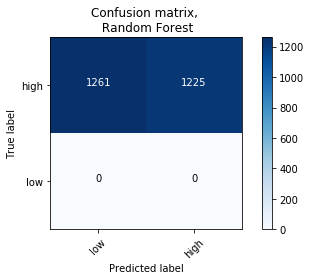

In [75]:
cnf_matrix = confusion_matrix(y_test, pred_rf_opt)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['low', 'high'],
                      title='Confusion matrix, \n Random Forest')

In [76]:
print(classification_report(y_test, pred_rf_opt, target_names=['low', 'high']))

              precision    recall  f1-score   support

         low       0.00      0.00      0.00         0
        high       1.00      0.49      0.66      2486

    accuracy                           0.49      2486
   macro avg       0.50      0.25      0.33      2486
weighted avg       1.00      0.49      0.66      2486



C:\Users\hamdanjuma\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural Net

In [77]:
# data_train_mm = scl_min_max.transform(X_train)
# data_test_mm = scl_min_max.transform(X_test)
# data_train_mm.shape

In [78]:
clf_nn = MLPClassifier(hidden_layer_sizes=(30,30,30,), early_stopping=False, learning_rate='adaptive', max_iter=1000)
clf_nn = clf_nn.fit(X_train, y_train.values.ravel())
pred_nn = clf_nn.predict(X_test)

In [79]:
print(f'The training score for Neural Net is: {(clf_nn.score(X_train, y_train)*100):.2f}%')
print(f'The test score for Neural Net is: {(clf_nn.score(X_test,y_test)*100):.2f}%')

The training score for Neural Net is: 92.40%
The test score for Neural Net is: 50.88%


## K-Nearest Neighbors Classification

In [80]:
knn_model = KNeighborsClassifier()
param_grid = {
    'n_neighbors':range(3,20),
    'weights': ['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree'],
    'metric':['manhattan','minkowski']
}
knn_model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [81]:
rs = RandomizedSearchCV(knn_model, param_distributions=param_grid)

In [82]:
rs.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree'],
                                        'metric': ['manhattan', 'minkowski'],
                                        'n_neighbors': range(3, 20),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_tra

In [83]:
rs_knn_pred = rs.predict(X_test)
print(f'The training score for K-Nearest Neighbors Classification is: {(knn_model.score(X_train,y_train)*100):.2f}%')
print(f'The test score for K-Nearest Neighbors Classification is: {(accuracy_score(y_test, rs_knn_pred)*100):.2f}%')

The training score for K-Nearest Neighbors Classification is: 88.40%
The test score for K-Nearest Neighbors Classification is: 50.04%


In [84]:
pred_knn = knn_model.predict(X_test)
print(f'The training score for K-Nearest Neighbors Classification is: {(knn_model.score(X_train,y_train)*100):.2f}%')
print(f'The test score for K-Nearest Neighbors Classification is: {(clf_nn.score(X_test,y_test)*100):.2f}%')

The training score for K-Nearest Neighbors Classification is: 88.40%
The test score for K-Nearest Neighbors Classification is: 50.88%


## Cross Validation

In [85]:
clf_nb = MultinomialNB()

In [86]:
# CV=10
nb_cv_train_scores = cross_val_score(clf_nb, X_train, y_train.values.ravel(), cv=10)
print("k-fold: Cross-validation scores with k-fold splitter: \n{}".format(nb_cv_train_scores))

k-fold: Cross-validation scores with k-fold splitter: 
[0.6  0.66 0.58 0.58 0.64 0.7  0.54 0.6  0.58 0.66]


In [87]:
print("Accuracy: %0.2f (+/- %0.2f)" % (nb_cv_train_scores.mean(), nb_cv_train_scores.std() * 2))

Accuracy: 0.61 (+/- 0.09)


In [88]:
nb_cv_pred = cross_val_predict(clf_nb, X_train, y_train.values.ravel(), cv=10)

In [89]:
accuracy_score(y_train, nb_cv_pred)

0.614

## Cross Validation splitter

In [90]:
kfold_splitter = KFold (n_splits = 5)
cv_scores_kfold = cross_val_score(clf_rf_opt, X_train, y_train.values.ravel(), cv=kfold_splitter)

In [91]:
print("k-fold: Cross-validation scores with k-fold splitter: \n{}".format(cv_scores_kfold))

k-fold: Cross-validation scores with k-fold splitter: 
[0.92 0.92 0.95 0.9  0.95]


In [92]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_kfold.mean(), cv_scores_kfold.std() * 2))

Accuracy: 0.93 (+/- 0.04)


In [93]:
kfold_cv_pred = cross_val_predict(clf_rf_opt, X_train, y_train.values.ravel(), cv=kfold_splitter)
accuracy_score(y_train, kfold_cv_pred)

0.926

In [94]:
kfold_cv_pred = cross_val_predict(clf_rf_opt, X_test, y_test.values.ravel(), cv=kfold_splitter)
accuracy_score(y_test, kfold_cv_pred)

1.0

## Logistic Regression

In [95]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X_train, y_train.values.ravel())

C:\Users\hamdanjuma\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [96]:
pred_log = clf_log.predict(X_test)

In [97]:
print(f'The training score for Logistic Regression is: {(clf_log.score(X_train, y_train)*100):.2f}%')
print(f'The test score for Logistic Regression is: {(clf_log.score(X_test,y_test)*100):.2f}%')

The training score for Logistic Regression is: 66.60%
The test score for Logistic Regression is: 70.56%


In [98]:
# accuracy of model
accuracy_score(y_test, pred_log)

0.7055510860820595

## Bagging Classifier

In [99]:
clf_bag = BaggingClassifier()
clf_bag = clf_bag.fit(X_train, y_train.values.ravel())

In [100]:
print(f'The training score for Bagging Classifier is: {(clf_bag.score(X_train,y_train)*100):.2f}%')
print(f'The test score for Bagging Classifier is: {(clf_bag.score(X_test,y_test)*100):.2f}%')

The training score for Bagging Classifier is: 99.60%
The test score for Bagging Classifier is: 47.51%


In [101]:
pred_bag = clf_bag.predict(X_test)
print(f'Accuracy of model {(100*accuracy_score(y_test, pred_bag)):.2f}%')

Accuracy of model 47.51%


## Boosting

In [102]:
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bagging = bagging.fit(X_train, y_train.values.ravel())

In [103]:
bagging_pred = bagging.predict(X_test)
accuracy_score(y_test, bagging_pred)

0.48149637972646825

## ExtraTrees Classifier

In [104]:
et = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
et = et.fit(X_train, y_train.values.ravel())

In [105]:
et_pred = et.predict(X_test)
accuracy_score(y_test, et_pred)

0.48390989541432017

## AdaBoost Classifier

In [106]:
ada = AdaBoostClassifier(n_estimators=100)
ada = ada.fit(X_train, y_train.values.ravel())

In [107]:
ada_pred = ada.predict(X_test)
accuracy_score(y_test, ada_pred)

0.501609010458568

## GradientBoostingClassifier

In [108]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbc = gbc.fit(X_train, y_train.values.ravel())

In [109]:
gbc_pred = gbc.predict(X_test)
accuracy_score(y_test, gbc_pred)

0.5144810941271118

## Voting

In [110]:
vote_clf_hard = VotingClassifier(estimators=[('bagging', bagging),('rf', clf_rf_opt),('et',et),('ada',ada),('gbc',gbc)], voting='hard')
vote_clf_hard = vote_clf_hard.fit(X_train, y_train.values.ravel())

In [111]:
vote_clf_hard_pred = vote_clf_hard.predict(X_test)
accuracy_score(y_test, vote_clf_hard_pred)

0.49597747385358004

In [112]:
vote_clf_soft = VotingClassifier(estimators=[('bagging', bagging),('rf', clf_gs_rf),('et',et),('ada',ada),('gbc',gbc)], voting='soft', weights=[3,2,2,1,1])
vote_clf_soft = vote_clf_soft.fit(X_train, y_train.values.ravel())

In [113]:
vote_clf_soft = vote_clf_soft.predict(X_test)
accuracy_score(y_test, vote_clf_soft)

0.4923572003218021

## Submission Process

In [114]:
# Y_pred = clf_dt.predict(X_test)
# Y_pred

In [115]:
ID = np.array(X_test['ID'].astype('int64'))
ID

array([12272,  6526, 11320, ..., 11032,  7213,  5262], dtype=int64)

In [127]:
submission = pd.DataFrame([ID, pred_rf_opt])
submission = submission.T
submission.rename(columns={0:'ID', 1:'COVID_TCPM'}, inplace=True)
submission

,ID,COVID_TCPM
0,12272,low
1,6526,low
2,11320,low
3,4566,high
4,4866,low
...,...,...
2481,1575,high
2482,13009,low
2483,11032,low
2484,7213,low


In [128]:
submission.to_csv('submission_pred_rf_opt.csv', index=False)

In [122]:
submission

,ID,COVID_TCPM
0,12272,low
1,6526,low
2,11320,low
3,4566,low
4,4866,low
...,...,...
2481,1575,high
2482,13009,high
2483,11032,low
2484,7213,low
